In [2]:
import glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

from xgboost import XGBRegressor
from sklearn import preprocessing
from sklearn import cross_validation, metrics
from sklearn.model_selection import GridSearchCV, cross_validate, KFold

# from sklearn.ensemble import ExtraTreesRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.ensemble import RandomForestRegressor

C:\Users\liumh\Anaconda3_5.0.1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [521]:
# import raw data
datapath = 'C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/'
data = {
    'tra': pd.read_csv(datapath + 'Data/air_visit_data.csv'),
    'as': pd.read_csv(datapath + 'Data/air_store_info.csv'),
    'hs': pd.read_csv(datapath + 'Data/hpg_store_info.csv'),
    'ar': pd.read_csv(datapath + 'Data/air_reserve.csv'),
    'hr': pd.read_csv(datapath + 'Data/hpg_reserve.csv'),
    'id': pd.read_csv(datapath + 'Data/store_id_relation.csv'),
    'tes': pd.read_csv(datapath + 'Data/sample_submission.csv'),
    'hol': pd.read_csv(datapath + 'Data/date_info.csv').rename(columns={'calendar_date':'visit_date'}),
    'airstat': pd.read_csv(datapath + 'rrv-weather-data/air_store_info_with_nearest_active_station.csv'),
    'hpgstat': pd.read_csv(datapath + 'rrv-weather-data/hpg_store_info_with_nearest_active_station.csv')
    }
data['hr'] = pd.merge(data['hr'], data['id'], how = 'inner', on = 'hpg_store_id')

### Data preprocessing & Feature Engineering

In [4]:
# change the holiday flag of golden week to 2, to distinguish these days from other holidays
golden_week = ['2016-04-29','2016-05-03','2016-05-04','2016-05-05','2017-04-29','2017-05-03','2017-05-04','2017-05-05']
index = []
for date in golden_week:
    i = data['hol'][data['hol']['visit_date'] == date].index
    data['hol'].iloc[i, 2] = 2

In [5]:
# dataetime features
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dayofyear'] = data['tra']['visit_date'].dt.dayofyear
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['weekofyear'] = data['tra']['visit_date'].dt.weekofyear
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: x.split('_')[2])
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dayofyear'] = data['tes']['visit_date'].dt.dayofyear
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['weekofyear'] = data['tes']['visit_date'].dt.weekofyear
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

data['tra']['month'][data['tra']['visit_date'] > pd.Timestamp('2016-12-31').date()] += 12
data['tes']['month'][data['tes']['visit_date'] > pd.Timestamp('2016-12-31').date()] += 11

C:\Users\liumh\Anaconda3_5.0.1\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\liumh\Anaconda3_5.0.1\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [6]:
lbl = preprocessing.LabelEncoder()
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date']).dt.date
train = pd.merge(data['tra'], data['hol'], how = 'left', on = ['visit_date'])
train.drop('day_of_week', axis = 1, inplace = True) 
test = pd.merge(data['tes'], data['hol'], how = 'left', on = ['visit_date']) 
test.drop('day_of_week', axis = 1, inplace = True) 

In [7]:
# features reflects time difference between visit data and reserve data
from functools import reduce
for df in ['ar', 'hr']:
    data[df]['reserve_date'] = pd.to_datetime(data[df]['reserve_datetime'])
    data[df]['visit_date'] = pd.to_datetime(data[df]['visit_datetime'])
    data[df]['vr_datediff'] = data[df]['visit_date'] - data[df]['reserve_date']
    data[df]['reserve_date'] = data[df]['reserve_date'].dt.date
    data[df]['visit_date'] = data[df]['visit_date'].dt.date
    data[df]['vr_hourdiff'] = data[df]['vr_datediff'].apply(lambda x: x.days*24 + x.seconds/3600)
    data[df]['vr_datediff'] = data[df]['vr_datediff'].apply(lambda x: x.days)
    
    tmp1 = data[df].groupby(['air_store_id', 'visit_date'], as_index = False)['vr_hourdiff'].sum().rename(columns = {'vr_hourdiff': 'vrhsum'})
    tmp2 = data[df].groupby(['air_store_id', 'visit_date'], as_index = False)['vr_hourdiff'].mean().rename(columns = {'vr_hourdiff': 'vrhmean'})
    tmp3 = data[df].groupby(['air_store_id', 'visit_date'], as_index = False)[['vr_datediff', 'reserve_visitors']]\
        .sum().rename(columns = {'vr_datediff': 'vrdsum', 'reserve_visitors': 'rdsum'})
    tmp4 = data[df].groupby(['air_store_id', 'visit_date'], as_index = False)[['vr_datediff', 'reserve_visitors']]\
        .mean().rename(columns = {'vr_datediff': 'vrdmean', 'reserve_visitors': 'rdmean'})  
    temps = [tmp1, tmp2, tmp3, tmp4]
    data[df] = reduce(lambda left, right: pd.merge(left, right, how = 'inner', on = ['air_store_id', 'visit_date']), temps)

In [421]:
def visitor_features(df, features):
    # features can be min, max, mean, median, count, std, var
    tmps = []
    columns = ['air_store_id']
    num = df.shape[0]/len(unique_stores)*max(1, 3*(not df.equals(stores)))/3 
    name = period_dict[num]
    if name != 'y':
        period = period_dict[name]
        columns.append(period)
    
    tmps.append(df)
    visit_data = data['tra']
    for feature in features:
        if df.equals(stores) and feature == 'mean':
            tmps.remove(df)
            columns.append('holiday_flg')
            subset = train.groupby(columns, as_index = False)['visitors']
            tmp = getattr(subset, 'mean')().rename(columns = {'visitors': name + 'mean' + '_visitors'})
            df = pd.merge(df, tmp, how = 'left', on = columns)
            columns.remove('holiday_flg')
            tmps.append(df)
        elif feature == ('std' or 'var'):
            subset = visit_data.groupby(columns, as_index = True)['visitors']
            tmp =  getattr(subset, feature)().reset_index().rename(columns = {'visitors': name + feature + '_visitors'})
            tmps.append(tmp)
        else: 
            subset = visit_data.groupby(columns, as_index = False)['visitors']
            tmp =  getattr(subset, feature)().rename(columns = {'visitors': name + feature + '_visitors'})
            tmps.append(tmp)
    df = reduce(lambda left, right: pd.merge(left, right, how = 'left', on = columns), tmps)
    return df

In [456]:
unique_stores = data['tra']['air_store_id'].unique()
period_dict = {7: '' , 53: 'w', 16: 'm', 1: 'y', '': 'dow', 'w': 'weekofyear', 'm': 'month'}
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores), 
                                     'holiday_flg': [0]*len(unique_stores)}) for i in range(7)], axis = 0, ignore_index = True)
for holiday_flg in [1,2]:
    storeso = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores),
                                     'holiday_flg': [holiday_flg]*len(unique_stores)}) for i in range(7)], axis = 0, ignore_index = True)
    stores = pd.concat([stores, storeso], axis = 0, ignore_index = True)
    
features = ['mean', 'min', 'max', 'median', 'count', 'std', 'var']

stores = visitor_features(stores, features)
stores = pd.merge(stores, data['as'], how = 'left', on = 'air_store_id')
storesm = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'month': [i]*len(unique_stores)}) for i in range(1, 17)], axis = 0, ignore_index = True)
storesm = visitor_features(storesm, features)
storesw = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'weekofyear': [i]*len(unique_stores)}) for i in range(1, 54)], axis = 0, ignore_index = True)
storesw = visitor_features(storesw, features[0:5])
storesy = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'total_stats': [0]*len(unique_stores)})], axis = 0, ignore_index = True)
storesy = visitor_features(storesy, features)
storesy = storesy.drop(['total_stats'], axis = 1)

In [10]:
stores['visitor_rangebyday'] = stores['max_visitors'] - stores['min_visitors']
storesm['visitor_rangebymonth'] = storesm['mmax_visitors'] - storesm['mmin_visitors']
storesw['visitor_rangebyweek'] = storesw['wmax_visitors'] - storesw['wmin_visitors']
storesy['visitor_rangebyyear'] = storesy['ymax_visitors'] - storesy['ymin_visitors']

In [11]:
stores.head(), stores.shape

(           air_store_id  dow  holiday_flg  mean_visitors  min_visitors  \
 0  air_ba937bf13d40fb24    0            0      13.754386           2.0   
 1  air_25e9888d30b386df    0            0       1.500000           1.0   
 2  air_8e4360a64dbd4c50    0            0      22.457143           2.0   
 3  air_35512c42db0868da    0            0       7.620000           2.0   
 4  air_a271c9ba19e81d17    0            0      20.142857           8.0   
 
    max_visitors  median_visitors  count_observs  std_visitors  var_visitors  \
 0          34.0             12.0           57.0      7.349151     54.010025   
 1           2.0              2.0            3.0      0.577350      0.333333   
 2          47.0             23.5           42.0      9.383802     88.055749   
 3          21.0              8.0           58.0      3.988830     15.910768   
 4          44.0             20.0           42.0      8.794862     77.349593   
 
   air_genre_name                         air_area_name   latitude

In [12]:
# store genres, areas and subareas
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(x).replace('/',' '))
lbl = preprocessing.LabelEncoder()
n1 = stores['air_genre_name'].map(lambda x: x.split(' ')).map(lambda x: len(x)).max()
n2 = stores['air_area_name'].map(lambda x: x.split(' ')).map(lambda x: len(x)).max()
for i in range(n1):
    stores['air_genre_name' + str(i)] = lbl.fit_transform(stores['air_genre_name']
                                                          .map(lambda x: x.split(' ')[i] if len(x.split(' ')) > i else ''))
for j in range(n2):    
    stores['air_area_name' + str(j)] = lbl.fit_transform(stores['air_area_name']
                                                         .map(lambda x: x.split(' ')[j] if len(x.split(' ')) > j else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

In [13]:
print(len(stores['air_area_name'].unique()), len(stores['air_area_name0'].unique()),
      len(stores['air_area_name1'].unique()), len(stores['air_area_name2'].unique()),
      len(stores['air_area_name3'].unique()), len(stores['air_area_name4'].unique()),
      len(stores['air_genre_name'].unique()), len(stores['air_genre_name0'].unique()),
      len(stores['air_genre_name1'].unique()), len(stores['air_genre_name2'].unique()))

103 9 55 99 12 5 14 14 10 3


In [14]:
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date']).dt.date

In [15]:
# weather features, max temp, min temp, max-min, aveg temp, wind speed, participation
feature_manifest = pd.read_csv('C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/rrv-weather-data/feature_manifest.csv')
air_active = pd.read_csv('C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/rrv-weather-data/air_store_info_with_nearest_active_station.csv')
hpg_active = pd.read_csv('C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/rrv-weather-data/hpg_store_info_with_nearest_active_station.csv')
air_active_station = pd.DataFrame(air_active.station_id.unique())
hpg_active_station = pd.DataFrame(hpg_active.station_id.unique())
active_station = pd.merge(air_active_station, hpg_active_station, how = 'outer').rename(columns = {0: 'id'})
# len(active_station) 38 for air, 54 for hpg, 62 in total
active_station_feature = pd.merge(active_station, feature_manifest, how = 'left', on = 'id')
active_station_feature.to_csv('C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/rrv-weather-data/active_station_feature.csv')
air_active.set_index('air_store_id', inplace = True)

feature_list = ['calendar_date', 'avg_temperature', 'high_temperature', 'low_temperature', 'precipitation', 
                'hours_sunlight', 'avg_wind_speed']
weather = pd.DataFrame()
air_stores = data['tra']['air_store_id'].unique()
for store in air_stores:
    station = air_active.loc[store, 'station_id']
    filepath = 'C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/rrv-weather-data/1-1-16_5-31-17_Weather/' + station + '.csv'
    station_weather = pd.read_csv(filepath)
    features = station_weather[feature_list]
    storedf = pd.DataFrame([store] * features.shape[0], columns = ['air_store_id'])
    weather = pd.concat([weather, pd.concat([storedf, features], axis = 1)], axis = 0)
    
weather = weather.rename(columns = {'calendar_date': 'visit_date'})
weather['temp_range'] = weather['high_temperature'] - weather['low_temperature']
weather['visit_date'] = pd.to_datetime(weather['visit_date']).dt.date
weather.head()

,air_store_id,visit_date,avg_temperature,high_temperature,low_temperature,precipitation,hours_sunlight,avg_wind_speed,temp_range
0,air_ba937bf13d40fb24,2016-01-01,7.5,12.1,3.6,NaN,9.0,2.6,8.5
1,air_ba937bf13d40fb24,2016-01-02,7.3,13.4,2.6,NaN,7.5,1.9,10.8
2,air_ba937bf13d40fb24,2016-01-03,9.3,16.2,3.0,NaN,8.3,1.4,13.2
3,air_ba937bf13d40fb24,2016-01-04,9.2,15.2,4.4,NaN,8.9,1.6,10.8
4,air_ba937bf13d40fb24,2016-01-05,10.9,15.4,5.1,NaN,8.4,1.8,10.3


In [16]:
train.shape, train.holiday_flg.unique(), stores.shape

((252108, 8), array([0, 1, 2], dtype=int64), (17409, 23))

In [17]:
train = pd.merge(train, stores, how = 'left', on = ['air_store_id','dow','holiday_flg']) 
test = pd.merge(test, stores, how = 'left', on = ['air_store_id','dow','holiday_flg'])
trainm = pd.merge(train, storesm, how = 'left', on = ['air_store_id','month']) 
testm = pd.merge(test, storesm, how = 'left', on = ['air_store_id','month'])
trainw = pd.merge(trainm, storesw, how = 'left', on = ['air_store_id','weekofyear']) 
testw = pd.merge(testm, storesw, how = 'left', on = ['air_store_id','weekofyear'])
traina = pd.merge(trainw, storesy, how = 'left', on = ['air_store_id'])
testa = pd.merge(testw, storesy, how = 'left', on = ['air_store_id'])

In [18]:
train.shape, trainm.shape, trainw.shape, traina.shape

((252108, 28), (252108, 36), (252108, 42), (252108, 50))

In [19]:
for df in ['ar', 'hr']:
    traina = pd.merge(traina, data[df], how = 'left', on = ['air_store_id','visit_date']) 
    testa = pd.merge(testa, data[df], how = 'left', on = ['air_store_id','visit_date'])
traina['id'] = traina.apply(lambda x: '_'.join([x['air_store_id'], str(x['visit_date'])]), axis = 1)

def total_reserve(df):
    df['total_reserv_sum'] = (df['rdsum_x'] + df['rdsum_y'])/2
    df['total_reserv_mean'] = (df['rdmean_x'] + df['rdmean_y']) / 2
    df['total_reserv_day_diff_mean'] = (df['vrdmean_x'] + df['vrdmean_y']) / 2
    df['total_reserv_hour_diff_mean'] = (df['vrhmean_x'] + df['vrhmean_y']) / 2
    return df

traina = total_reserve(traina)
testa = total_reserve(testa)

In [21]:
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int) 
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
traina['date_int'] = traina['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int) 
testa['date_int'] = testa['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)

def coordinate_features(df):
    df['var_max_lat'] = df['latitude'].max() - df['latitude']
    df['var_max_long'] = df['longitude'].max() - df['longitude']
    df['lon_plus_lat'] = df['longitude'] + df['latitude'] 
    lbl = preprocessing.LabelEncoder()
    df['air_store_id2'] = lbl.fit_transform(df['air_store_id'])
    return df
traina = coordinate_features(traina)
testa = coordinate_features(testa)
traina['visitors'] = np.log1p(traina['visitors'].values)

traina = pd.merge(traina, weather, how = 'left', on = ['air_store_id', 'visit_date'])
testa = pd.merge(testa, weather, how = 'left', on = ['air_store_id', 'visit_date'])
traina = traina.sample(frac = 1).reset_index(drop = True)
print('Pre-processing done!')

Pre-processing done!


In [ ]:
######## features did not used for getting final prediction results
avgtemp_area= traina.groupby(['air_area_name', 'month'], as_index = False)['avg_temperature'].mean().rename(columns = {'avg_temperature': 'avg_temp_area'})
precipitation_area = traina.groupby(['air_area_name', 'month'], as_index = False)['precipitation'].mean().rename(columns = {'precipitation': 'precipitation_area'})
sunlight_area = traina.groupby(['air_area_name', 'month'], as_index = False)['hours_sunlight'].mean().rename(columns = {'hours_sunlight': 'sunlight_area'})
windspeed_area = traina.groupby(['air_area_name', 'month'], as_index = False)['avg_wind_speed'].mean().rename(columns = {'avg_wind_speed': 'windspeed_area'})
temprange_area = traina.groupby(['air_area_name', 'month'], as_index = False)['temp_range'].mean().rename(columns = {'temp_range': 'temprange_area'})
for df in [avgtemp_area, precipitation_area, sunlight_area, windspeed_area, temprange_area]:
    traina = pd.merge(traina, df, how = 'left', on = ['air_area_name', 'month'])
    testa = pd.merge(testa, df, how = 'left', on = ['air_area_name', 'month'])
    
stores_genre_area = traina.groupby(['air_area_name','air_genre_name'], as_index = False)['air_store_id'].\
apply(lambda x: len(x.unique())).reset_index().rename(columns={0: 'stores_genre_area'})
meanvisitors_genre_area = traina.groupby(['air_area_name','air_genre_name'], as_index=False)['visitors'].mean().rename(columns = {'visitors': 'meanvisitors_genre_area'})
minvisitors_genre_area = traina.groupby(['air_area_name','air_genre_name'], as_index=False)['visitors'].min().rename(columns = {'visitors': 'minvisitors_genre_area'})
maxvisitors_genre_area = traina.groupby(['air_area_name','air_genre_name'], as_index=False)['visitors'].max().rename(columns = {'visitors': 'maxvisitors_genre_area'})
for df in [stores_genre_area, meanvisitors_genre_area, minvisitors_genre_area, maxvisitors_genre_area]:
    traina = pd.merge(traina, df, how = 'left', on = ['air_area_name','air_genre_name'])
    testa = pd.merge(testa, df, how = 'left', on = ['air_area_name','air_genre_name'])

traina['dow_flg'] = traina.apply(lambda x: '_'.join([str(x['dow']), str(x['holiday_flg'])]), axis = 1)
testa['dow_flg'] = testa.apply(lambda x: '_'.join([str(x['dow']), str(x['holiday_flg'])]), axis = 1)
traina['date_flg'] = traina.apply(lambda x: '_'.join([str(x['date_int']), str(x['holiday_flg'])]), axis = 1)
testa['date_flg'] = testa.apply(lambda x: '_'.join([str(x['date_int']), str(x['holiday_flg'])]), axis = 1)
traina['lat_long'] = traina.apply(lambda x: '_'.join([str(x['latitude']), str(x['longitude'])]), axis = 1)
testa['lat_long'] = testa.apply(lambda x: '_'.join([str(x['latitude']), str(x['longitude'])]), axis = 1)

In [519]:
cola = [c for c in traina if c not in ['id', 'air_store_id', 'visit_date','visitors','air_genre_name0',
                                       'air_genre_name1','air_genre_name2','air_area_name4','dayofyear']]
traina[cola].shape, testa[cola].shape

((252108, 70), (32019, 70))

In [73]:
# from datetime import timedelta
# tm = str(traina.visit_date[0].year)+'-'+str(traina.visit_date[0].month)+'-'+str(traina.visit_date[0].day)
# tm1 = pd.to_datetime(tm)
# tm2 = tm1 + timedelta(days = 39)
# tm2.strftime('%Y%m%d')

### Functions for splitting data, cross validation, prediction, evaluation and plotting

In [98]:
##########  functions for splitting data, cross validation, prediction, evaluation and plotting  ########## 

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

def time_split(X, split_date, time_series = True):
    # X is the training dataframe
    # split_date is a list of dates for splitting data
    split_data = []
    if len(split_date) > 1 and time_series == False:
        date = pd.Timestamp(split_date[0]).date()
        Xtrain_index = X[X['visit_date'] <= date].index.values
        split_data.append(Xtrain_index)
        for i in range(1, len(split_date)):
            date1 = pd.Timestamp(split_date[i - 1]).date()
            date2 = pd.Timestamp(split_date[i]).date()
            sub = X[X['visit_date'] > date1]
            Xtrain_index = sub[sub['visit_date'] <= date2].index.values
            split_data.append(Xtrain_index)
    elif len(split_date) == 1:
        date = pd.Timestamp(split_date[0]).date()
        Xtrain_index = X[X['visit_date'] <= date].index.values
        split_data.append(Xtrain_index)
        Xtest_index = X[X['visit_date'] > date].index.values
        split_data.append(Xtest_index)
    else:
        for i in range(len(split_date) - 1):
            date1 = pd.Timestamp(split_date[i]).date()
            date2 = pd.Timestamp(split_date[i + 1]).date()
            Xtrain_index = X[X['visit_date'] <= date1].index.values
            sub = X[X['visit_date'] > date1]
            Xtest_index = sub[sub['visit_date'] <= date2].index.values
            split_data.append((Xtrain_index, Xtest_index))
    return split_data

def modelcv(model, eval_sets=[], early_stopping_rounds = 0):
    # return best rmse evaluation score, best number of estimator and evaluation results 
    rmse = []
    estimators = []
    results = []
    if early_stopping_rounds > 0:
        for eval_set in eval_sets:
            model.fit(eval_set[0][0],eval_set[0][1], eval_set = eval_set, eval_metric = 'rmse', 
                      early_stopping_rounds = early_stopping_rounds, verbose = False)
            estimators.append(model.best_iteration)
            rmse.append(model.best_score)
            result = model.evals_result()
            results.append(result)
        rmse_mean = np.array(rmse).mean()
        rmse_std = np.array(rmse).std()
        rmse.append({'mean': rmse_mean, 'std': rmse_std})
        return rmse, estimators, results
    else:
        for eval_set in eval_sets:
            model.fit(eval_set[0][0], eval_set[0][1], eval_set = eval_set, eval_metric = 'rmse', verbose = False)
            result = model.evals_result()
            results.append(result)
        return results
    
def predict(model, train, test, col):
    model.fit(train[col], train['visitors'], eval_metric = 'rmse')
    train_pred = model.predict(train[col])
    test_pred = model.predict(test[col])
    print('train RMSE: %f' % RMSLE(train['visitors'], train_pred))
    print('test RMSE: %f' % RMSLE(test['visitors'], test_pred))
    return train_pred, test_pred
    
def plotcv(results):
    i = 1
    for res in results:
        estimators = len(res['validation_0']['rmse'])
        x_lim = range(0, estimators)
        title = 'model__' + str(i)
        plt.rcParams['figure.figsize'] = (5.0, 5.0)
        fig, ax = plt.subplots()
        ax.plot(x_lim, res['validation_0']['rmse'], label = 'train')
        ax.plot(x_lim, res['validation_1']['rmse'], label = 'test')
        ax.legend()
        plt.ylabel('rmse')
        plt.title(title)
        plt.show()
        i += 1

In [99]:
cola = [c for c in traina if c not in ['id', 'air_store_id', 'visit_date','visitors','air_genre_name0',
                                       'air_genre_name1','air_genre_name2','air_area_name4','dayofyear']]
split_date = ['2017-03-14']
split_data = time_split(traina, split_date)
trainacv = traina.iloc[split_data[0], :].reset_index(drop = True) # use trainacv for cross validation
testacv = traina.iloc[split_data[1], :].reset_index(drop = True)  # testacv data only used for prediction

kf = KFold(n_splits = 5, shuffle = True, random_state = 66)

eval_setsa = []
for train_index, test_index in kf.split(trainacv):
    Xtrain = trainacv[cola].iloc[train_index, :].reset_index(drop = True)
    Ytrain = trainacv['visitors'][train_index].reset_index(drop = True)
    Xtest = trainacv[cola].iloc[test_index, :].reset_index(drop = True)
    Ytest = trainacv['visitors'][test_index].reset_index(drop = True)
    eval_setsa.append([(Xtrain, Ytrain), (Xtest, Ytest)])

In [101]:
for eval_set in eval_setsa:
    print(eval_set[0][0].shape, eval_set[0][1].shape, eval_set[1][0].shape, eval_set[1][1].shape)

(179261, 70) (179261,) (44816, 70) (44816,)
(179261, 70) (179261,) (44816, 70) (44816,)
(179262, 70) (179262,) (44815, 70) (44815,)
(179262, 70) (179262,) (44815, 70) (44815,)
(179262, 70) (179262,) (44815, 70) (44815,)


### XGBoost

In [33]:
xgb1 = XGBRegressor(learning_rate = 0.03, n_estimators = 2000, max_depth = 5, min_child_weight = 1, 
                    gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1,reg_alpha = 1, seed = 66)
rmse, estimators, results = modelcv(xgb1, eval_sets = eval_setsa, early_stopping_rounds = 50)

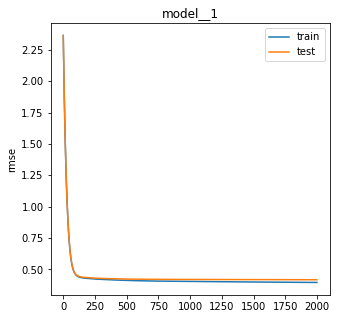

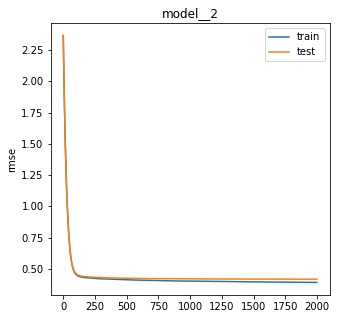

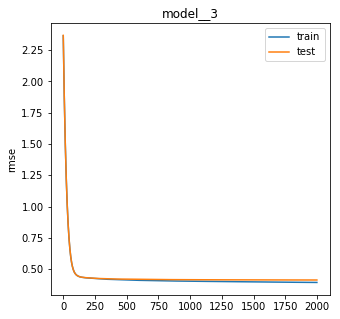

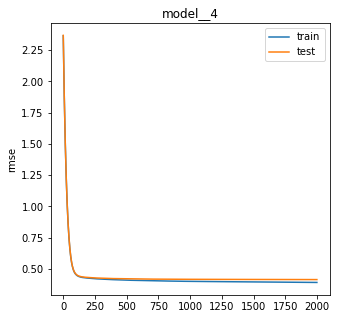

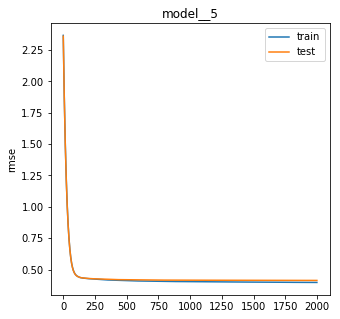

([0.417192,
  0.41687,
  0.412874,
  0.416116,
  0.41425,
  {'mean': 0.41546040000000001, 'std': 0.0016474073691713259}],
 [1994, 1994, 1999, 1993, 1999],
 None)

In [49]:
rmse, estimators, plotcv(results)

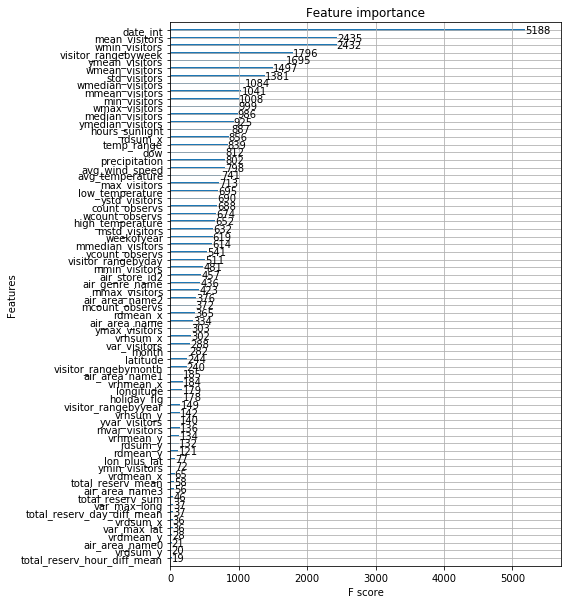

In [35]:
import xgboost as xgb
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 10.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
xgb.plot_importance(xgb1, height = 0.2)

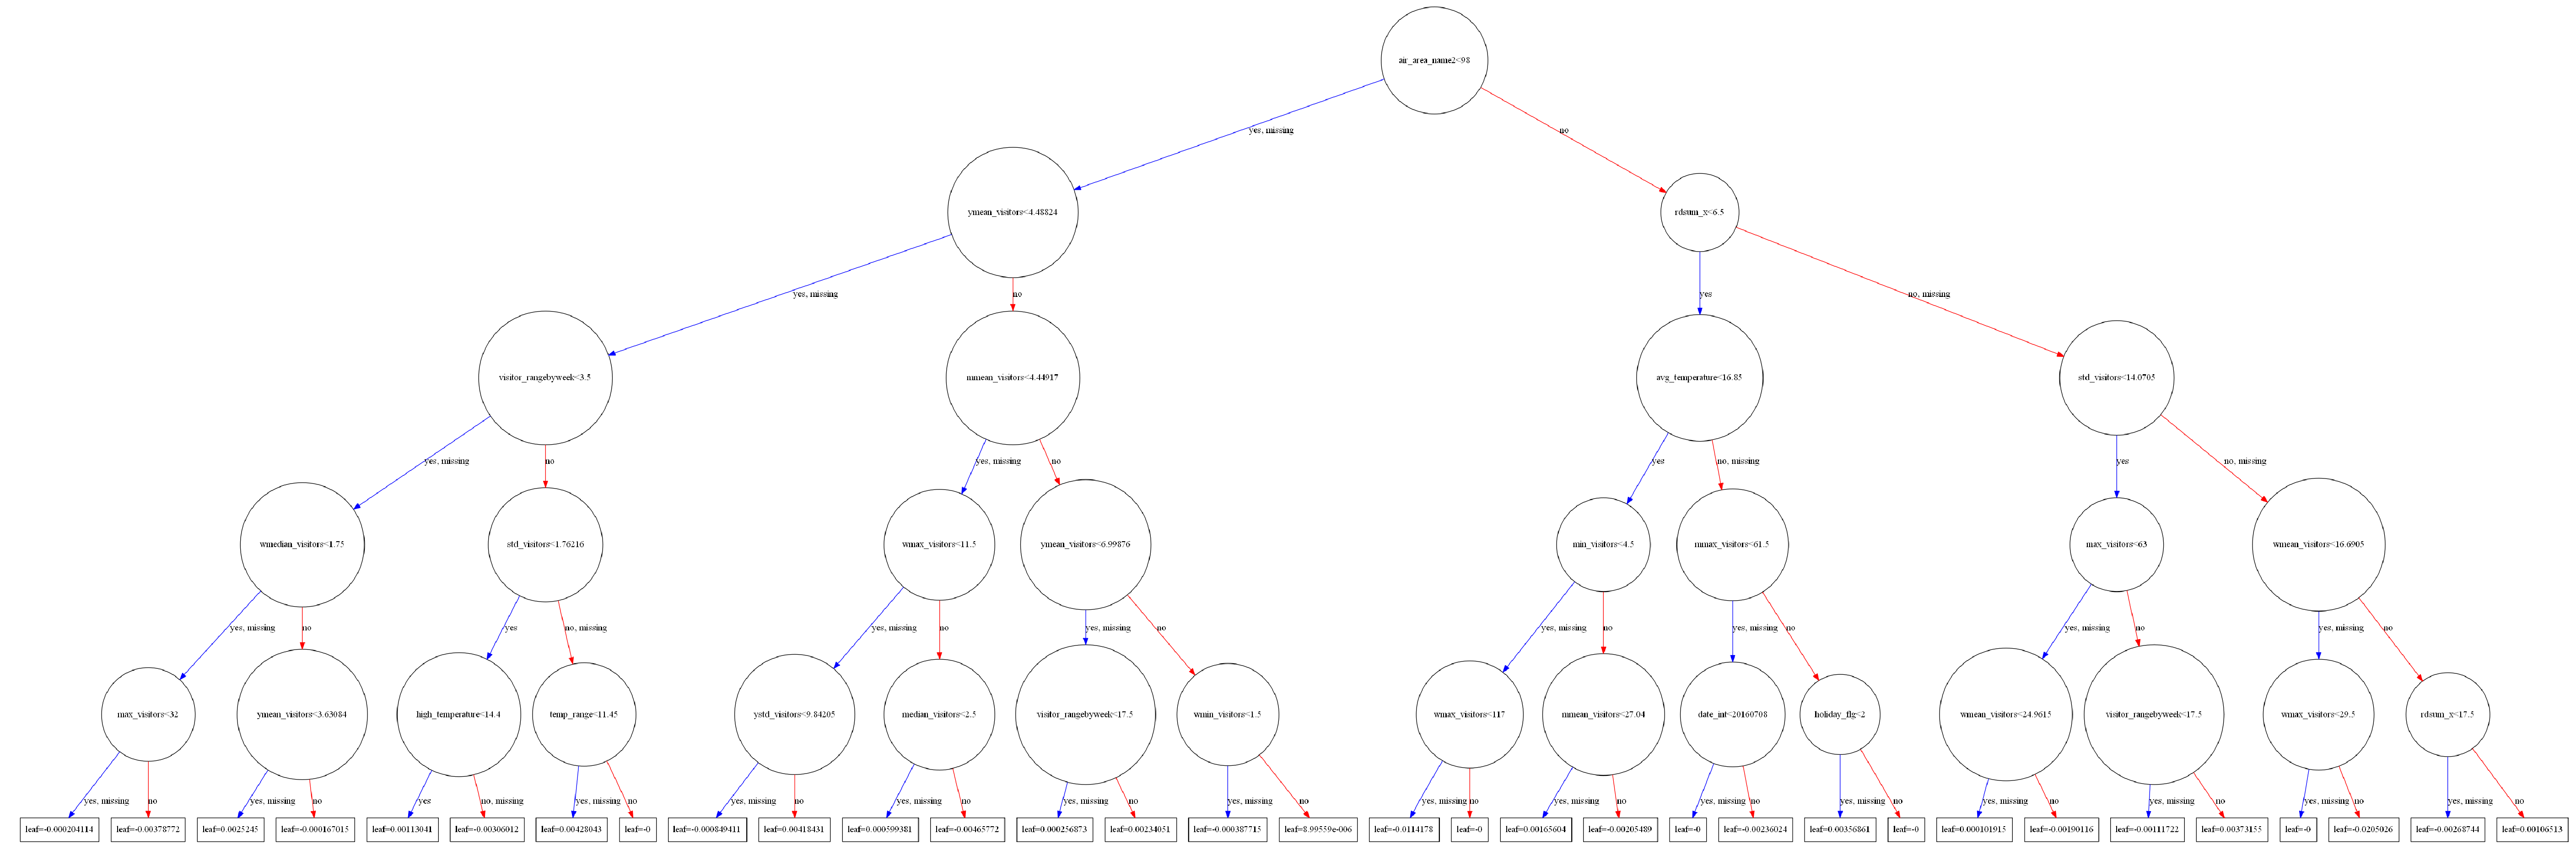

In [36]:
plt.rcParams['figure.figsize'] = (100.0, 200.0) # set default size of plots
xgb.plot_tree(xgb1, num_trees = 500)

In [50]:
trainpred, testpred = predict(xgb1, traina, testa, cola)

train RMSE: 0.402218
test RMSE: 2.064386


In [ ]:
###########  XGBRegressor ensembles ########## 
trainpreds = {}
testpreds = {}
models = {}
for i in range(10):
    traina = traina.sample(frac = 1).reset_index(drop = True)
    xgb1 = XGBRegressor(learning_rate = 0.03, n_estimators = 2000, max_depth = 5, min_child_weight = 1, 
                        gamma = 0, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1, 
                        reg_alpha = 1, seed = np.random.randint(10000))
    xgb1.fit(traina[cola], traina['visitors'], eval_metric = 'rmse')
    param = str(i)
    models[param] = xgb1
    trainpred = xgb1.predict(traina[cola])
    testpred = xgb1.predict(testa[cola])
    trainpreds[param] = trainpred
    testpreds[param] = testpred
    print(param)
    print('trainpred:', RMSLE(traina.visitors, trainpred))

In [ ]:
######### Average over prediction results of ensembles #########
testpred0 = testpreds[str(0)]
for i in range(1,10):
    param = str(i)
    testpred0 += testpreds[param]
testpred0 = testpred0/10
pd.DataFrame(testpred0).to_csv('../data/testpred_xgb.csv', index = False)

### CatBoost

In [473]:
# categorical features
for i in [0,1,2,3,11,12,16,17,18,19,58,62]:
    print(traina[cola].columns[i])

month
weekofyear
dow
holiday_flg
air_genre_name
air_area_name
air_area_name0
air_area_name1
air_area_name2
air_area_name3
date_int
air_store_id2


In [ ]:
# Catboost ensemble
# should tune one_hot_max_size parameter to obtain better result
# reference https://towardsdatascience.com/catboost-vs-light-gbm-vs-xgboost-5f93620723db
cat_features_indices = np.array([0,1,2,3,11,12,16,17,18,19,58,62])
trainpreds = {}
testpreds = {}
models = {}
for i in range(10):
    traina = traina.sample(frac=1).reset_index(drop=True)
    cbr1 = CatBoostRegressor(learning_rate = 0.1, iterations = 1500, depth=7, eval_metric = 'RMSE', 
                             random_seed = np.random.randint(10000))
    cbr1.fit(traina[cola], traina.visitors, cat_features = cat_features_indices, plot = False)
    param = str(i)
    model = cbr1.copy()
    models[param] = model
    trainpred = cbr1.predict(traina[cola])
    testpred = cbr1.predict(testa[cola])
    trainpreds[param] = trainpred
    testpreds[param] = testpred
    print(param)
    print('trainpred:', RMSLE(traina.visitors, trainpred))

In [ ]:
testpred0 = testpreds[str(0)]
for i in range(1,10):
    param = str(i)
    testpred0 += testpreds[param]
testpred0 = testpred0/10
pd.DataFrame(testpred0).to_csv('../data/testpred_catboost.csv', index=False)

In [ ]:
# GridSearch example 
# Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
param_test1 = {'max_depth': range(2,10,2)}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate = 0.1, n_estimators = 800, max_depth = 5,
                                                 min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                 scale_pos_weight = 1, seed = 66), param_grid = param_test1,
                        scoring = 'neg_mean_squared_error', cv = 5)

gsearch1.fit(traina[colm], traina['visitors'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

In [ ]:
# weighted mean visitors
dfs = {re.search(r'.*\\(.*).csv', fn).group(1):
    pd.read_csv(fn) for fn in glob.glob('C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/Data/*.csv')}
for k, v in dfs.items(): locals()[k] = v
wkend_holidays = date_info.apply((lambda x:(x.day_of_week == 'Sunday' or x.day_of_week == 'Saturday') and x.holiday_flg == 1), axis = 1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5 # weighted mean

visit_data = air_visit_data.merge(date_info, left_on = 'visit_date', right_on = 'calendar_date', how = 'left')
visit_data.drop('calendar_date', axis = 1, inplace = True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:((x.weight * x.visitors).sum() / x.weight.sum())
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0: 'visitors'}, inplace = True)

lbl = preprocessing.LabelEncoder()
visitors.rename(columns = {"day_of_week": "dow", "visitors": "weighted_visitors"}, inplace = True)
visitors.dow = lbl.fit_transform(visitors.dow)
date_info.rename(columns = {"day_of_week": "dow", "calendar_date": "visit_date"}, inplace = True)
date_info.dow = lbl.transform(date_info.dow)
date_info.visit_date = pd.to_datetime(date_info.visit_date).dt.date

def visitors_pred(pred, df):
    # pred is the prediction result on dataframe df
    # return the dataframe with columns = ['air_store_id', 'visit_date', 'holiday_flg', 'visitors', 'pred', 'dow', 'weighted_visitors']
    df1 = df.loc[:, ['air_store_id', 'visit_date', 'holiday_flg', 'visitors']]
    df1['pred'] = pred
    df1 = df1.merge(date_info.loc[:,['visit_date', 'dow']], on = 'visit_date', how = 'left')
    df1 = df1.merge(visitors, on = ['air_store_id', 'dow', 'holiday_flg'], how = 'left')
    missings1 = df1.weighted_visitors.isnull()
    df1.loc[missings1, 'weighted_visitors'] = df1[missings1].merge(
        visitors[visitors.holiday_flg == 0], on = ['air_store_id', 'dow'], how = 'left')['weighted_visitors_y'].values
    missings1 = df1.weighted_visitors.isnull()
    df1.loc[missings1, 'weighted_visitors'] = df1[missings1].merge(
        visitors[['air_store_id', 'weighted_visitors']].groupby('air_store_id').mean().reset_index(), 
        on = 'air_store_id', how = 'left')['weighted_visitors_y'].values
    return df1

testapred = visitors_pred(testpred, testa)
testapred[['pred', 'weighted_visitors']] = np.expm1(testapred[['pred', 'weighted_visitors']]).clip(lower=0.)

sample_submission.visitors = testapred['pred']*0.3 + testapred['weighted_visitors']*0.7
sample_submission.to_csv('C:/Users/liumh/OneDrive/Recruit Restaurant Visitor Forecasting/Data/20181.csv', index=False)

In [ ]:
# plot prediction results versus visitors
trainpred1 = visitors_pred(trainpred, trainacv)
testpred1 = visitors_pred(testpred, testacv)
trainapred = pd.concat([trainpred1, testpred1], axis = 0, ignore_index = True)
print(RMSLE(trainapred.visitors, trainapred.pred))

plotbyid = {}       
score_dict = {}
score_list = []
plt.rcParams['figure.figsize'] = (5.0, 3.0)
for id in unique_stores[0:50]:
    sub = trainapred[['air_store_id', 'visit_date', 'visitors','pred']][trainapred['air_store_id'] == id]
    sub = sub.sort_values(by = 'visit_date').reset_index(drop = True)
    plotbyid[id] = sub
    score = RMSLE(sub['visitors'], sub['pred'])
    score_dict[id] = score
    
    x_lim = range(0, sub.shape[0])
    title = id
    fig, ax = plt.subplots()
    ax.scatter(x_lim, sub['visitors'], label = 'visitors')
    ax.scatter(x_lim, sub['pred'], label = 'pred')
    ax.legend()
    plt.ylabel('rmse')
    plt.title(title)
    plt.show()

### H2O autoML

In [ ]:
# H2O autoML
import h2o
from h2o.automl import H2OAutoML
h2o.init()

In [ ]:
trainmh2o = trainm.copy()
trainmh2o.head()

In [ ]:
trainyh2o = trainy.copy()
testyh2o = testy.copy()
trainyh2o = trainyh2o.fillna(-999)
testyh2o = testyh2o.fillna(-999)
print('Pre-processing done!')

htrain = h2o.H2OFrame(trainyh2o)
htest = h2o.H2OFrame(testyh2o)
htrain.drop(['id', 'air_store_id', 'visit_date'])
htest.drop(['id', 'air_store_id', 'visit_date'])
x =htrain.columns
y ='visitors'
x.remove(y)

print('Starting h2o autoML model!')  
aml = H2OAutoML(max_runtime_secs = 25200)
aml.train(x=x, y =y, training_frame=htrain, leaderboard_frame = htest)
print('h2o autoML model finished!')

In [ ]:
print('Generate predictions...')
htrain.drop(['visitors'])
trainyh2opreds = aml.leader.predict(htrain)
trainyh2opreds = trainmh2opreds.as_data_frame()
print('RMSLE H2O automl leader: ', RMSLE(trainyh2o['visitors'], trainyh2opreds))

testyh2opreds = aml.leader.predict(htest)
testyh2opreds = testmh2opreds.as_data_frame()

testyh2o['visitors'] = testyh2opreds
testyh2o['visitors'] = np.expm1(testmh2o['visitors']).clip(lower=0.)
subh2o = testyh2o[['id','visitors']].copy()

lb = aml.leaderboard
print(lb)

In [ ]:
RMSLE(trainmh2o.visitors, trainmh2opreds)

In [ ]:
aml.leader.predict(htest).as_data_frame().to_csv('../data/testmh2opreds.csv',index = False)

In [ ]:
h2o.cluster().shutdown(prompt=True) 